In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ViT

/content/drive/MyDrive/ViT


In [ ]:
!ls

Data		    inference.py	   quick_inference.py  utils.py
dataset.py	    Main_Collab_ViT.ipynb  README.md	       wandb
demo_multimodal.py  model.py		   requirements.txt
evaluate.py	    notebook		   test_inference.py
experiments	    __pycache__		   train.py


In [ ]:
# Do not unzip again if you already unzipped it
!unzip Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/ThermalAug/T_Sad_2140_KTFE_clahe.jpg  
  inflating: Data/ThermalAug/T_Sad_2140_KTFE_flip.jpg  
  inflating: Data/ThermalAug/T_Sad_2140_KTFE_rotate15.jpg  
  inflating: Data/ThermalAug/T_Sad_2140_KTFE_rotate15neg.jpg  
  inflating: Data/ThermalAug/T_Sad_2141_KTFE_clahe.jpg  
  inflating: Data/ThermalAug/T_Sad_2141_KTFE_flip.jpg  
  inflating: Data/ThermalAug/T_Sad_2141_KTFE_rotate15.jpg  
  inflating: Data/ThermalAug/T_Sad_2141_KTFE_rotate15neg.jpg  
  inflating: Data/ThermalAug/T_Sad_2142_KTFE_clahe.jpg  
  inflating: Data/ThermalAug/T_Sad_2142_KTFE_flip.jpg  
  inflating: Data/ThermalAug/T_Sad_2142_KTFE_rotate15.jpg  
  inflating: Data/ThermalAug/T_Sad_2142_KTFE_rotate15neg.jpg  
  inflating: Data/ThermalAug/T_Sad_2143_KTFE_clahe.jpg  
  inflating: Data/ThermalAug/T_Sad_2143_KTFE_flip.jpg  
  inflating: Data/ThermalAug/T_Sad_2143_KTFE_rotate15.jpg  
  inflating: Data/ThermalAug/T_Sad_2143_KTFE_rotate15neg.jpg  
  inf

In [ ]:
!pip install -r requirements.txt

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import logging
from datetime import datetime
import wandb
from typing import Dict, List, Tuple, Optional, Union

from dataset import create_multimodal_data_loaders, MultiModalFERDataset
from model import create_multimodal_vit_model, get_optimizer_and_scheduler, ViTForFER, EarlyFusionViT, LateFusionViT
from utils import EarlyStopping, MetricsTracker, save_checkpoint, load_checkpoint, PerformanceAnalyzer

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class MultiModalFERTrainer:
    """
    Trainer class for Fine-tuning ViT on multimodal FER dataset
    Supports RGB-only, Thermal-only, and Combined (RGB+Thermal) modes
    """

    def __init__(
        self,
        model: Union[ViTForFER, EarlyFusionViT, LateFusionViT],
        train_loader: DataLoader,
        test_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler._LRScheduler,
        device: torch.device,
        config: Dict,
        mode: str = 'rgb',
        experiment_name: str = None
    ):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.config = config
        self.mode = mode.lower()

        # Setup experiment tracking
        self.experiment_name = experiment_name or f"multimodal_vit_fer_{self.mode}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        self.save_dir = os.path.join(config['output_dir'], self.experiment_name)
        os.makedirs(self.save_dir, exist_ok=True)

        # Setup file logging
        self.setup_file_logging()

        # Initialise tracking
        self.tensorboard_writer = SummaryWriter(os.path.join(self.save_dir, 'tensorboard'))
        self.metrics_tracker = MetricsTracker()
        self.early_stopping = EarlyStopping(
            patience=config['early_stopping_patience'],
            min_delta=config['early_stopping_min_delta']
        )

        # Class names for metrics
        self.class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']

        # Initialise WandB if configured
        if config.get('use_wandb', False):
            wandb.init(
                project=config['wandb_project'],
                name=self.experiment_name,
                config=config
            )
            wandb.watch(self.model)

        # Loss function with class weights
        if config.get('use_class_weights', False):
            class_weights = self._get_class_weights()
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.criterion = nn.CrossEntropyLoss()

        # File logger for training progress
        self.file_logger.info(f"Trainer initialized. Experiment: {self.experiment_name}")
        self.file_logger.info(f"Save directory: {self.save_dir}")
        self.file_logger.info(f"Training mode: {self.mode}")
        if self.mode == 'combined':
            self.file_logger.info(f"Fusion strategy: {config.get('fusion_strategy', 'early')}")
            self.file_logger.info(f"Fusion type: {config.get('fusion_type', 'concat')}")
            self.file_logger.info(f"Fusion layer: {config.get('fusion_layer', 'feature')}")
        self.file_logger.info(f"Training samples: {len(self.train_loader.dataset):,}")
        self.file_logger.info(f"Test samples: {len(self.test_loader.dataset):,}")
        self.file_logger.info(f"Use augmented data: {config.get('use_augmented', False)}")
        self.file_logger.info(f"Training configuration: {json.dumps(config, indent=2)}")

        logger.info(f"Trainer initialized. Experiment: {self.experiment_name}")
        logger.info(f"Save directory: {self.save_dir}")
        logger.info(f"Training mode: {self.mode}")

    def setup_file_logging(self):
        """Setup file logging for training progress"""
        log_file = os.path.join(self.save_dir, 'training_log.txt')

        # Create file logger
        self.file_logger = logging.getLogger(f'file_logger_{self.experiment_name}')
        self.file_logger.setLevel(logging.INFO)

        # Create file handler
        file_handler = logging.FileHandler(log_file)
        file_handler.setLevel(logging.INFO)

        # Create formatter
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)

        # Add handler to logger
        self.file_logger.addHandler(file_handler)

    def _get_class_weights(self) -> torch.Tensor:
        """Calculate class weights for imbalanced dataset"""
        # Create a temporary dataset to get class weights
        temp_dataset = MultiModalFERDataset(
            data_dir=self.config['data_dir'],
            mode=self.mode,
            split_ratio=0.8,
            split_type='train',
            use_augmented=self.config.get('use_augmented', False)
        )
        class_weights = temp_dataset.get_class_weights().to(self.device)
        self.file_logger.info(f"Class weights: {class_weights}")
        return class_weights

    def train_epoch(self) -> Dict[str, float]:
        """Train for one epoch"""
        self.model.train()

        total_loss = 0
        predictions = []
        targets = []

        # Progress bar
        pbar = tqdm(self.train_loader, desc="Training")

        for batch_idx, batch in enumerate(pbar):
            # Handle different input formats based on mode
            if self.mode == 'combined':
                data, labels = batch
                rgb_images = data['rgb'].to(self.device)
                thermal_images = data['thermal'].to(self.device)
                labels = labels.to(self.device)

                # Forward pass for combined mode
                outputs = self.model(rgb_images, thermal_images, labels)
            else:
                # Single modality mode (RGB or Thermal)
                images, labels = batch
                images = images.to(self.device)
                labels = labels.to(self.device)

                # Forward pass for single modality
                outputs = self.model(images, labels)

            loss = outputs['loss']
            logits = outputs['logits']

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            if self.config.get('gradient_clip_norm', None):
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    self.config['gradient_clip_norm']
                )

            self.optimizer.step()
            self.scheduler.step()

            # Track metrics
            total_loss += loss.item()
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'LR': f'{self.scheduler.get_last_lr()[0]:.6f}'
            })

        # Calculate epoch metrics
        epoch_loss = total_loss / len(self.train_loader)
        epoch_acc = accuracy_score(targets, predictions)
        epoch_f1 = f1_score(targets, predictions, average='weighted')

        metrics = {
            'loss': epoch_loss,
            'accuracy': epoch_acc,
            'f1_score': epoch_f1,
            'precision': precision_score(targets, predictions, average='weighted'),
            'recall': recall_score(targets, predictions, average='weighted')
        }

        return metrics

    def validate_epoch(self, loader: DataLoader) -> Dict[str, float]:
        """Validate for one epoch"""
        self.model.eval()

        total_loss = 0
        predictions = []
        targets = []

        with torch.no_grad():
            for batch in tqdm(loader, desc="Validating"):
                # Handle different input formats based on mode
                if self.mode == 'combined':
                    data, labels = batch
                    rgb_images = data['rgb'].to(self.device)
                    thermal_images = data['thermal'].to(self.device)
                    labels = labels.to(self.device)

                    # Forward pass for combined mode
                    outputs = self.model(rgb_images, thermal_images, labels)
                else:
                    # Single modality mode (RGB or Thermal)
                    images, labels = batch
                    images = images.to(self.device)
                    labels = labels.to(self.device)

                    # Forward pass for single modality
                    outputs = self.model(images, labels)

                loss = outputs['loss']
                logits = outputs['logits']

                # Track metrics
                total_loss += loss.item()
                predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
                targets.extend(labels.cpu().numpy())

        # Calculate epoch metrics
        epoch_loss = total_loss / len(loader)
        epoch_acc = accuracy_score(targets, predictions)
        epoch_f1 = f1_score(targets, predictions, average='weighted')

        metrics = {
            'loss': epoch_loss,
            'accuracy': epoch_acc,
            'f1_score': epoch_f1,
            'precision': precision_score(targets, predictions, average='weighted'),
            'recall': recall_score(targets, predictions, average='weighted'),
            'predictions': predictions,
            'targets': targets
        }

        return metrics

    def train(self, num_epochs: int) -> Dict:
        """Main training loop"""
        self.file_logger.info(f"Starting training for {num_epochs} epochs")
        logger.info(f"Starting training for {num_epochs} epochs")

        best_f1 = 0.0

        for epoch in range(num_epochs):
            self.file_logger.info(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
            logger.info(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")

            # Training phase
            train_metrics = self.train_epoch()

            # Validation phase on test set (since we don't have separate validation)
            val_metrics = self.validate_epoch(self.test_loader)

            # Log metrics
            self._log_metrics(epoch, train_metrics, val_metrics)

            # Track metrics
            self.metrics_tracker.update(
                epoch + 1,
                {
                    'loss': train_metrics['loss'],
                    'accuracy': train_metrics['accuracy'],
                    'f1': train_metrics['f1_score'],
                    'precision': train_metrics['precision'],
                    'recall': train_metrics['recall']
                },
                {
                    'loss': val_metrics['loss'],
                    'accuracy': val_metrics['accuracy'],
                    'f1': val_metrics['f1_score'],
                    'precision': val_metrics['precision'],
                    'recall': val_metrics['recall']
                }
            )

            # Check for best model (based on validation F1 score)
            if val_metrics['f1_score'] > best_f1:
                best_f1 = val_metrics['f1_score']
                self._save_checkpoint('best_model.pth', epoch, val_metrics)
                self.file_logger.info(f"New best model saved with F1: {best_f1:.4f}")

            # Early stopping check
            if self.early_stopping(val_metrics['loss']):
                self.file_logger.info(f"Early stopping triggered at epoch {epoch + 1}")
                logger.info(f"Early stopping triggered at epoch {epoch + 1}")
                break

        # Save final model
        self._save_checkpoint('last_model.pth', epoch, val_metrics)

        # Generate final results
        final_results = self._generate_final_results(val_metrics)

        # Close logging
        self.tensorboard_writer.close()

        if self.config.get('use_wandb', False):
            wandb.finish()

        self.file_logger.info("Training completed!")
        logger.info("Training completed!")

        return final_results

    def _log_metrics(self, epoch: int, train_metrics: Dict, val_metrics: Dict):
        """Log metrics to various tracking systems"""
        # Console logging
        logger.info(f"Train - Loss: {train_metrics['loss']:.4f}, "
                   f"Acc: {train_metrics['accuracy']:.4f}, "
                   f"F1: {train_metrics['f1_score']:.4f}")
        logger.info(f"Val   - Loss: {val_metrics['loss']:.4f}, "
                   f"Acc: {val_metrics['accuracy']:.4f}, "
                   f"F1: {val_metrics['f1_score']:.4f}")

        # File logging
        self.file_logger.info(f"Train - Loss: {train_metrics['loss']:.4f}, "
                             f"Acc: {train_metrics['accuracy']:.4f}, "
                             f"F1: {train_metrics['f1_score']:.4f}, "
                             f"Precision: {train_metrics['precision']:.4f}, "
                             f"Recall: {train_metrics['recall']:.4f}")
        self.file_logger.info(f"Val   - Loss: {val_metrics['loss']:.4f}, "
                             f"Acc: {val_metrics['accuracy']:.4f}, "
                             f"F1: {val_metrics['f1_score']:.4f}, "
                             f"Precision: {val_metrics['precision']:.4f}, "
                             f"Recall: {val_metrics['recall']:.4f}")

        # TensorBoard logging
        self.tensorboard_writer.add_scalars('Loss', {
            'Train': train_metrics['loss'],
            'Val': val_metrics['loss']
        }, epoch)

        self.tensorboard_writer.add_scalars('Accuracy', {
            'Train': train_metrics['accuracy'],
            'Val': val_metrics['accuracy']
        }, epoch)

        self.tensorboard_writer.add_scalars('F1 Score', {
            'Train': train_metrics['f1_score'],
            'Val': val_metrics['f1_score']
        }, epoch)

        # WandB logging
        if self.config.get('use_wandb', False):
            wandb.log({
                'epoch': epoch,
                'train_loss': train_metrics['loss'],
                'val_loss': val_metrics['loss'],
                'train_accuracy': train_metrics['accuracy'],
                'val_accuracy': val_metrics['accuracy'],
                'train_f1': train_metrics['f1_score'],
                'val_f1': val_metrics['f1_score'],
                'learning_rate': self.scheduler.get_last_lr()[0]
            })

    def _save_checkpoint(self, filename: str, epoch: int, metrics: Dict):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'metrics': metrics,
            'config': self.config,
            'mode': self.mode
        }

        save_path = os.path.join(self.save_dir, filename)
        torch.save(checkpoint, save_path)
        self.file_logger.info(f"Checkpoint saved: {save_path}")

    def _generate_final_results(self, final_metrics: Dict) -> Dict:
        """Generate and save final results with detailed evaluation metrics"""
        # Create performance analyzer
        analyzer = PerformanceAnalyzer(self.class_names)

        # Generate comprehensive analysis
        detailed_analysis = analyzer.generate_detailed_analysis(
            final_metrics['targets'],
            final_metrics['predictions'],
            self.save_dir
        )

        # Calculate additional metrics
        from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

        # Overall metrics
        overall_accuracy = accuracy_score(final_metrics['targets'], final_metrics['predictions'])

        # Macro and Micro averages
        macro_f1 = f1_score(final_metrics['targets'], final_metrics['predictions'], average='macro')
        micro_f1 = f1_score(final_metrics['targets'], final_metrics['predictions'], average='micro')
        macro_precision = precision_score(final_metrics['targets'], final_metrics['predictions'], average='macro')
        micro_precision = precision_score(final_metrics['targets'], final_metrics['predictions'], average='micro')
        macro_recall = recall_score(final_metrics['targets'], final_metrics['predictions'], average='macro')
        micro_recall = recall_score(final_metrics['targets'], final_metrics['predictions'], average='micro')

        # Per-class accuracy
        per_class_accuracy = []
        cm = confusion_matrix(final_metrics['targets'], final_metrics['predictions'])
        for i in range(len(self.class_names)):
            if cm[i, :].sum() > 0:
                class_accuracy = cm[i, i] / cm[i, :].sum()
            else:
                class_accuracy = 0.0
            per_class_accuracy.append(class_accuracy)

        # Create comprehensive results dictionary
        results = {
            'mode': self.mode,
            'experiment_name': self.experiment_name,
            'final_metrics': {
                'overall_accuracy': float(overall_accuracy),
                'weighted_f1_score': float(final_metrics['f1_score']),
                'weighted_precision': float(final_metrics['precision']),
                'weighted_recall': float(final_metrics['recall']),
                'macro_f1_score': float(macro_f1),
                'micro_f1_score': float(micro_f1),
                'macro_precision': float(macro_precision),
                'micro_precision': float(micro_precision),
                'macro_recall': float(macro_recall),
                'micro_recall': float(micro_recall)
            },
            'per_class_metrics': {
                'classes': self.class_names,
                'accuracy': per_class_accuracy,
                'f1_scores': detailed_analysis['class_performance'][self.class_names[0]]['f1_score'] if self.class_names else [],
                'precision': [detailed_analysis['class_performance'][class_name]['precision'] for class_name in self.class_names],
                'recall': [detailed_analysis['class_performance'][class_name]['recall'] for class_name in self.class_names]
            },
            'confusion_matrix': cm.tolist(),
            'training_history': self.metrics_tracker.get_history(),
            'detailed_analysis': detailed_analysis
        }

        # Fix per-class F1 scores extraction
        results['per_class_metrics']['f1_scores'] = [
            detailed_analysis['class_performance'][class_name]['f1_score']
            for class_name in self.class_names
        ]

        # Save comprehensive results
        results_file = os.path.join(self.save_dir, 'final_results.json')
        with open(results_file, 'w') as f:
            json.dump(results, f, indent=2)

        # Save evaluation summary
        evaluation_summary = {
            'experiment_name': self.experiment_name,
            'mode': self.mode,
            'overall_accuracy': float(overall_accuracy),
            'macro_f1_score': float(macro_f1),
            'micro_f1_score': float(micro_f1),
            'weighted_f1_score': float(final_metrics['f1_score']),
            'per_class_accuracy': {
                class_name: float(acc) for class_name, acc in zip(self.class_names, per_class_accuracy)
            }
        }

        summary_file = os.path.join(self.save_dir, 'evaluation_summary.json')
        with open(summary_file, 'w') as f:
            json.dump(evaluation_summary, f, indent=2)

        # Plot training history
        self.metrics_tracker.plot_metrics(self.save_dir)

        # Log detailed results
        self.file_logger.info("=== DETAILED EVALUATION RESULTS ===")
        self.file_logger.info(f"Overall Accuracy: {overall_accuracy:.4f}")
        self.file_logger.info(f"Macro F1-Score: {macro_f1:.4f}")
        self.file_logger.info(f"Micro F1-Score: {micro_f1:.4f}")
        self.file_logger.info(f"Weighted F1-Score: {final_metrics['f1_score']:.4f}")
        self.file_logger.info("Per-class Accuracy:")
        for class_name, acc in zip(self.class_names, per_class_accuracy):
            self.file_logger.info(f"  {class_name}: {acc:.4f}")
        self.file_logger.info("Final evaluation completed with comprehensive metrics")

        return results


def main(data_dir):
    """Main training function"""
    # Configuration
    config = {
        'data_dir': data_dir,
        'output_dir': './experiments',
        'mode': 'thermal',  # 'rgb', 'thermal', or 'combined'
        'fusion_strategy': '',  # 'early' or 'late' (for combined mode)
        'fusion_type': '',  # 'concat', 'add', or 'attention' (for early fusion)
        'fusion_layer': '',  # 'feature' or 'prediction' (for late fusion)

        # Model parameters
        'model_name': 'google/vit-base-patch16-224-in21k',
        'num_classes': 7,
        'dropout_rate': 0.1,
        'freeze_backbone': False,
        'use_gradient_checkpointing': False,

        # Training parameters
        'batch_size': 32,
        'num_epochs': 30,
        'learning_rate': 5e-5,
        'weight_decay': 0.01,
        'warmup_steps': 500,
        'gradient_clip_norm': 1.0,

        # Data parameters
        'image_size': 224,
        'num_workers': 4,
        'val_split': 0.2,
        'use_augmented': True,
        'use_class_weights': True,

        # Early stopping
        'early_stopping_patience': 10,
        'early_stopping_min_delta': 0.001,

        # Logging
        'use_wandb': True,
        'wandb_project': 'multimodal-fer'
    }

    # Device setup
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    # Create data loaders
    logger.info("Creating data loaders...")
    train_loader, test_loader = create_multimodal_data_loaders(
        data_dir=config['data_dir'],
        mode=config['mode'],
        batch_size=config['batch_size'],
        image_size=config['image_size'],
        num_workers=config['num_workers'],
        val_split=config['val_split'],
        use_augmented=config['use_augmented']
    )

    # Log dataset information
    train_samples = len(train_loader.dataset)
    test_samples = len(test_loader.dataset)
    logger.info(f"=== DATASET INFORMATION ===")
    logger.info(f"Training Mode: {config['mode'].upper()}")
    if config['mode'] == 'combined':
        logger.info(f"Fusion Strategy: {config['fusion_strategy']}")
        logger.info(f"Fusion Type: {config['fusion_type']}")
        logger.info(f"Fusion Layer: {config['fusion_layer']}")
    logger.info(f"Use Augmented Data: {config['use_augmented']}")
    logger.info(f"Training Samples: {train_samples:,}")
    logger.info(f"Test Samples: {test_samples:,}")
    logger.info(f"Train Batches: {len(train_loader)}, Test Batches: {len(test_loader)}")
    logger.info(f"Batch Size: {config['batch_size']}")

    # Create model
    logger.info("Creating model...")
    model = create_multimodal_vit_model(
        mode=config['mode'],
        fusion_strategy=config['fusion_strategy'],
        fusion_type=config['fusion_type'],
        fusion_layer=config['fusion_layer'],
        model_name=config['model_name'],
        num_classes=config['num_classes'],
        dropout_rate=config['dropout_rate'],
        freeze_backbone=config['freeze_backbone'],
        use_gradient_checkpointing=config['use_gradient_checkpointing']
    )

    model.to(device)

    # Calculate total training steps
    total_steps = len(train_loader) * config['num_epochs']

    # Create optimizer and scheduler
    optimizer, scheduler = get_optimizer_and_scheduler(
        model=model,
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        warmup_steps=config['warmup_steps'],
        num_training_steps=total_steps
    )

    # Create trainer
    trainer = MultiModalFERTrainer(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        config=config,
        mode=config['mode']
    )

    # Start training
    logger.info("Starting training...")
    results = trainer.train(config['num_epochs'])

    # Print final results
    logger.info("Training completed!")


In [ ]:
"""Main training execution command
   Edit the config dictionary in main() to customise training parameters
"""
data_dir = 'Data'
main(data_dir)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: reicraftscodes (reicraftscodes-university-of-the-west-of-england) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


INFO:file_logger_multimodal_vit_fer_thermal_20250822_193734:Class weights: tensor([0.7590, 2.6634, 1.6918, 0.4908, 5.9129, 0.6691, 0.9855],
       device='cuda:0')
INFO:file_logger_multimodal_vit_fer_thermal_20250822_193734:Trainer initialized. Experiment: multimodal_vit_fer_thermal_20250822_193734
INFO:file_logger_multimodal_vit_fer_thermal_20250822_193734:Save directory: ./experiments/multimodal_vit_fer_thermal_20250822_193734
INFO:file_logger_multimodal_vit_fer_thermal_20250822_193734:Training mode: thermal
INFO:file_logger_multimodal_vit_fer_thermal_20250822_193734:Training samples: 16,556
INFO:file_logger_multimodal_vit_fer_thermal_20250822_193734:Test samples: 4,139
INFO:file_logger_multimodal_vit_fer_thermal_20250822_193734:Use augmented data: True
INFO:file_logger_multimodal_vit_fer_thermal_20250822_193734:Training configuration: {
  "data_dir": "Data",
  "output_dir": "./experiments",
  "mode": "thermal",
  "fusion_strategy": "",
  "fusion_type": "",
  "fusion_layer": "",
  "m

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁
train_accuracy,▁▅▆▇▇▇▇███████████████████████
train_f1,▁▅▆▇▇▇▇███████████████████████
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇▇█████████████████████
val_f1,▁▅▆▆▇▇▇▇▇█████████████████████
val_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
learning_rate,0
train_accuracy,0.99492


INFO:file_logger_multimodal_vit_fer_thermal_20250822_193734:Training completed!


**Inference**

In [ ]:
import os
from inference import MultiModalFERInference
# Load model
print(f"Loading model...")
inferencer = MultiModalFERInference('experiments/multimodal_vit_fer_thermal_20250822_193734/best_model.pth')
print(f"✓ Model loaded successfully!")
print(f"Mode: {inferencer.mode}")

Loading model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


✓ Model loaded successfully!
Mode: thermal


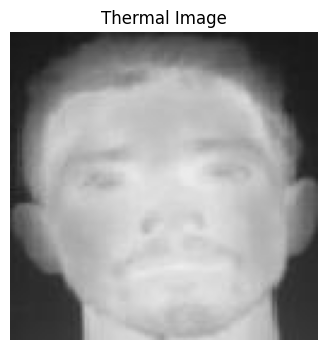


Running inference...

🕒 Inference Time: 18.71 ms

🎭 EMOTION RECOGNITION RESULT
📊 Model Mode: THERMAL
😊 Predicted Emotion: HAPPY
🎯 Confidence: 100.0%

🏆 Top 3 Predictions:
   🥇 happy: 100.0%
   🥈 surprised: 0.0%
   🥉 fear: 0.0%

📈 All Emotion Probabilities:
        angry: ░░░░░░░░░░░░░░░░░░░░   0.0%
      disgust: ░░░░░░░░░░░░░░░░░░░░   0.0%
         fear: ░░░░░░░░░░░░░░░░░░░░   0.0%
        happy: ███████████████████░ 100.0%
      neutral: ░░░░░░░░░░░░░░░░░░░░   0.0%
          sad: ░░░░░░░░░░░░░░░░░░░░   0.0%
    surprised: ░░░░░░░░░░░░░░░░░░░░   0.0%


In [ ]:
# Run inference - Thermal
from PIL import Image
import matplotlib.pyplot as plt
import time

# Load Thermal image
thermal_img = Image.open('Data/NewDataImages/Sets/T_1-TD-A-4.jpg')

# Plot the RGB image only
plt.figure(figsize=(4, 4))
plt.imshow(thermal_img)
plt.title('Thermal Image')
plt.axis('off')
plt.show()


print(f"\nRunning inference...")

start_time = time.time()
# inferencer.predict_single(rgb_path, thermal_path)
result = inferencer.predict_single('Data/NewDataImages/006.jpg','Data/NewDataImages/006.jpeg')

end_time = time.time()

inference_time = (end_time - start_time) * 1000  # milliseconds

print(f"\n🕒 Inference Time: {inference_time:.2f} ms")

# Display results
print("\n" + "="*60)
print("🎭 EMOTION RECOGNITION RESULT")
print("="*60)
print(f"📊 Model Mode: {result['mode'].upper()}")
print(f"😊 Predicted Emotion: {result['predicted_class'].upper()}")
print(f"🎯 Confidence: {result['confidence_percent']:.1f}%")

print(f"\n🏆 Top 3 Predictions:")
for i, pred in enumerate(result['top3_predictions'], 1):
    emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
    print(f"   {emoji} {pred['class']}: {pred['confidence']:.1f}%")

print(f"\n📈 All Emotion Probabilities:")
for emotion, prob in result['all_probabilities'].items():
    bar_length = int(prob * 20)  # Scale to 20 chars
    bar = "█" * bar_length + "░" * (20 - bar_length)
    print(f"   {emotion:>10}: {bar} {prob*100:5.1f}%")